# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [1]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._

In [2]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [3]:
import random
import datetime

maps = {}

train = train.drop(columns=["Inspection ID", "DBA Name", "AKA Name", "License #", "Address", "Location", "Violations"])
cols = ["Facility Type", "Risk", "City", "State", "Zip", "Inspection Type"]
for c in cols:
    maps[c] = {}
    for v in train[c].astype('category').cat.categories:
        maps[c][v] = random.uniform(0.0, 1.0)
    maps[c][None] = -1.0
    train[c] = train[c].apply(lambda x: maps[c].get(x, maps[c][None]))
train["Inspection Date"] = pd.to_numeric(pd.to_datetime(train["Inspection Date"]))
lat_min = train["Latitude"].min() - 1.0
long_min = train["Longitude"].min() - 1.0
train["Latitude"] = train["Latitude"].fillna(lat_min)
train["Longitude"] = train["Longitude"].fillna(long_min)

test = test.drop(columns=["Inspection ID", "DBA Name", "AKA Name", "License #", "Address", "Location", "Violations"])
cols = ["Facility Type", "Risk", "City", "State", "Zip", "Inspection Type"]
for c in cols:
    test[c] = test[c].apply(lambda x: maps[c].get(x, maps[c][None]))
test["Inspection Date"] = pd.to_numeric(pd.to_datetime(test["Inspection Date"]))
test["Latitude"] = test["Latitude"].fillna(lat_min)
test["Longitude"] = test["Longitude"].fillna(long_min)

In [4]:
train.head()

,Facility Type,Risk,City,State,Zip,Inspection Date,Inspection Type,Latitude,Longitude,Fail
0,0.701935,0.561850,0.905688,0.656862,0.313564,1505433600000000000,0.555830,41.938007,-87.644755,1
1,0.114203,0.317772,0.905688,0.656862,0.318829,1319068800000000000,0.620661,41.772402,-87.683603,0
2,0.701935,0.561850,0.905688,0.656862,0.133440,1459814400000000000,0.885769,41.758779,-87.575054,0
3,0.701935,0.096585,0.905688,0.656862,0.967941,1461888000000000000,0.555830,41.812181,-87.707125,0
4,0.762864,0.561850,0.905688,0.656862,0.469302,1294617600000000000,0.555830,40.644670,-88.914428,0


In [5]:
test.head()

,Facility Type,Risk,City,State,Zip,Inspection Date,Inspection Type,Latitude,Longitude,Fail
0,0.114203,0.096585,0.905688,0.656862,0.748875,1300752000000000000,0.555830,41.874481,-87.629357,0
1,0.701935,0.561850,0.905688,0.656862,0.522921,1442275200000000000,0.555830,41.844070,-87.729807,0
2,0.701935,0.561850,0.905688,0.656862,0.202949,1330646400000000000,0.555830,41.925128,-87.662041,0
3,0.701935,0.561850,0.905688,0.656862,0.615162,1475539200000000000,0.885769,41.869546,-87.655501,1
4,0.762864,0.096585,0.905688,0.656862,0.859355,1460073600000000000,0.555830,41.743933,-87.599291,1


In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn import tree

In [7]:
dec_cols = [c for c in train if c != "Fail"]
model = DecisionTreeClassifier().fit(train[dec_cols], train["Fail"])
print(roc_auc_score(test["Fail"], model.predict_proba(test[dec_cols])[:,1]))

0.6030092360985027


In [8]:
for i in range(1, 10+1):
    model = DecisionTreeClassifier(max_depth=i).fit(train[dec_cols], train["Fail"])
    print(i, roc_auc_score(test["Fail"], model.predict_proba(test[dec_cols])[:,1]))

1 0.6089101334103116
2 0.6628878819583681
3 0.6745003742246105
4 0.688097732925975
5 0.691317092115856
6 0.6955561273783074
7 0.7013838691123846
8 0.7014059873325296
9 0.6973504549256362
10 0.6933519422453216


In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(train[dec_cols], train["Fail"])
print("NULL", roc_auc_score(test["Fail"], model.predict_proba(test[dec_cols])[:,1]))
for i in range(2, 30+1, 2):
    model = RandomForestClassifier(max_depth=i, n_estimators=100, n_jobs=-1).fit(train[dec_cols], train["Fail"])
    print(i, roc_auc_score(test["Fail"], model.predict_proba(test[dec_cols])[:,1]))

NULL 0.7293136603085492
2 0.6885277842724651
4 0.7017581372627135
6 0.7098777097540916
8 0.7180049539588349
10 0.72666214723507
12 0.734669535068917
14 0.7424790606200329
16 0.743412519173841
18 0.7442243362248117
20 0.7410981522142819
22 0.7392960310421383
24 0.7373920963936416
26 0.7342954236618804
28 0.7320048381429578
30 0.7314672434819826


In [11]:
from xgboost import XGBClassifier

In [12]:
model = XGBClassifier(n_estimators=100, n_jobs=-1).fit(train[dec_cols], train["Fail"])
print("NULL", roc_auc_score(test["Fail"], model.predict_proba(test[dec_cols])[:,1]))
for i in range(2, 20+1, 2):
    model = XGBClassifier(max_depth=i, n_estimators=100, n_jobs=-1).fit(train[dec_cols], train["Fail"])
    print(i, roc_auc_score(test["Fail"], model.predict_proba(test[dec_cols])[:,1]))

NULL 0.717266013830854
2 0.705078099522412
4 0.7260213371160715
6 0.7382359848638228
8 0.7433376742517358
10 0.7405447090648565
12 0.7425175498062695
14 0.7405116623540491
16 0.7379924754511703
18 0.7374496298899009
20 0.7355219050928072


In [13]:
model = XGBClassifier(booster='dart', n_estimators=100, n_jobs=-1).fit(train[dec_cols], train["Fail"])
print("NULL", roc_auc_score(test["Fail"], model.predict_proba(test[dec_cols])[:,1]))
for i in range(2, 20+1, 2):
    model = XGBClassifier(booster='dart', max_depth=i, n_estimators=100, n_jobs=-1).fit(train[dec_cols], train["Fail"])
    print(i, roc_auc_score(test["Fail"], model.predict_proba(test[dec_cols])[:,1]))

NULL 0.717266013830854
2 0.705078099522412
4 0.7260213371160715
6 0.7382359848638228
8 0.7433376742517358
10 0.7405447090648565
12 0.7425175498062695
14 0.7405116623540491
16 0.7379924754511703
18 0.7374496298899009
20 0.7355219050928072


In [14]:
model = XGBClassifier(booster='dart', max_depth=10, n_estimators=100, n_jobs=-1).fit(train[dec_cols], train["Fail"])
print(roc_auc_score(test["Fail"], model.predict_proba(test[dec_cols])[:,1]))

0.7405447090648565


In [15]:
import xgboost as xgb

In [16]:
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['Fail'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Fail'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("AUC Score (Train): {}".format(roc_auc_score(dtrain['Fail'], dtrain_predprob)))
    print("AUC Score (Test): {}".format(roc_auc_score(dtest['Fail'], dtest_predprob)))
    
    return alg

In [17]:
train["Fail"] = train["Fail"].astype(bool)
test["Fail"] = test["Fail"].astype(bool)

xgb1 = XGBClassifier(
    booster='dart',
    n_estimators=100,
    max_depth=10,
    objective= 'binary:logistic',
    n_jobs=-1,
    seed=27
)
model = modelfit(xgb1, train, test, dec_cols)


Model Report
AUC Score (Train): 0.8799684225033522
AUC Score (Test): 0.7405447090648565


In [18]:
import matplotlib.pyplot as plt

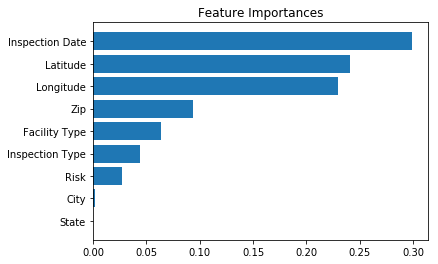

In [19]:
importances = sorted([(model.feature_importances_[i], dec_cols[i]) for i in range(len(dec_cols))])

plt.barh([i+1 for i in range(len(dec_cols))], [i[0] for i in importances])
plt.yticks([i+1 for i in range(len(dec_cols))], [i[1] for i in importances])
plt.title("Feature Importances")
plt.show()

In [20]:
import eli5
from eli5.sklearn import PermutationImportance


Model Report
AUC Score (Train): 0.8799684225033522
AUC Score (Test): 0.7405447090648565


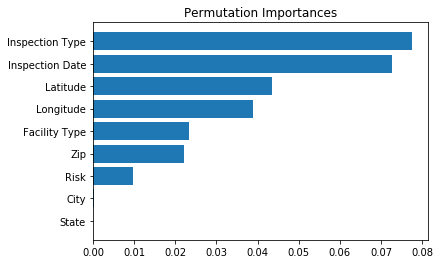

In [22]:
cols = ["f{}".format(i) for i in range(len(dec_cols))]
train[cols] = train[dec_cols]
test[cols] = test[dec_cols]
model = modelfit(xgb1, train, test, cols)
perm = PermutationImportance(model, random_state=1).fit(train[cols], train["Fail"])
importances = sorted([(r, dec_cols[i]) for i, r in enumerate(perm.feature_importances_)])

plt.barh([i+1 for i in range(len(dec_cols))], [i[0] for i in importances])
plt.yticks([i+1 for i in range(len(dec_cols))], [i[1] for i in importances])
plt.title("Permutation Importances")
plt.show()